In [1]:
from datetime import datetime
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import astropy.units as u
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

In [ ]:
# instantiate all of the WFS systems...
wfs_keys = ['newf9', 'f9', 'f5', 'mmirs']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name

In [ ]:
def check_wfs(p):
    """
    Check to see which system was used on a given night
    """
    if Path.exists(p / "F9"):  # wow, i really like pathlib.Path...
        return "f9"
    elif Path.exists(p / "F5"):
        return "f5"
    elif Path.exists(p / "MMIRS"):
        return 'mmirs'
    else:
        return None

def process_image(f):
    """
    Process FITS file, f, to get info we want from the header and then analyse it with the 
    appropriate WFS instance. Return results in a comma-separated line that will be collected 
    and saved in a CSV file.
    """
    if "ave" not in f.name:
        with fits.open(f) as h:
            hdr = h[0].header
            if 'AIRMASS' in hdr:
                airmass = hdr['AIRMASS']
            else:
                airmass = np.nan
            # we need to fix the headers in all cases to have a proper DATE-OBS entry with
            # properly formatted FITS timestamp.  in the meantime, this hack gets us what we need 
            # for analysis in pandas.
            if 'DATEOBS' not in hdr:
                return None
            dateobs = hdr['DATEOBS']
            ut = hdr['ut']
            timestring = dateobs + " " + ut + " UTC"
            dtime = datetime.strptime(timestring , "%a %b %d %Y %H:%M:%S %Z")
            obstime = dtime.isoformat()
            # being conservative here and only using data that has proper slope determination
            # and wavefront solution. also want to get statistics on the quality of the wavefront fits.
            results = wfs_systems[wfskey].measure_slopes(f, plot=False)
            if results['slopes'] is not None:
                zresults = wfs_systems[wfskey].fit_wavefront(results, plot=False)
                line = "%s,%s,%s,%f,%f,%f,%f,%f\n" % (
                    obstime,
                    wfskey,
                    f.name, 
                    airmass,
                    results['seeing'].value,
                    results['raw_seeing'].value,
                    results['fwhm'],
                    zresults['residual_rms'].value
                )
                zfile = f.parent / (f.stem + ".zernike")
                zresults['zernike'].save(filename=zfile)
                return line
            else:
                return None
    return None

In [ ]:
#rootdir = Path("/Users/tim/MMT/wfsdat/test")
rootdir = Path("/Volumes/LaCie/wfsdat")
dirs = rootdir.glob("*")  # pathlib, where have you been all my life!
csv_header = "time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms\n"
for d in dirs:
    if d.is_dir():
        if Path.exists(d / "seeing_results.csv"):
            print("Already processed %s..." % d.name)
        else:
            try:
                lines = []
                lines.append(csv_header)
                night = int(d.name)  # valid WFS directories are ints of the form YYYYMMDD. if not this form, int barfs
                msg = "checking %d... " % night
                wfskey = check_wfs(d)
                if wfskey is not None:
                    if wfskey == "mmirs":
                        rawd = d / "rawdata"
                        fitsfiles = rawd.glob("*.fits")
                    else:
                        fitsfiles = d.glob("*.fits")
                    if wfskey == "f9" and night > 20170510:
                        wfskey = "newf9"
                    msg += " using %s." % wfskey
                    print(msg)
                    with Pool(processes=8) as pool:  # my mac's i7 has 4 cores + hyperthreading so 8 virtual cores. 
                        plines = pool.map(process_image, fitsfiles)  # plines comes out in same order as fitslines!
                    plines = list(filter(None.__ne__, plines))  # trim out any None entries
                    lines.extend(plines)
                    with open(d / "seeing_results.csv", "w") as f:
                        f.writelines(lines)
                else:
                    msg = "No valid wfskey for %s..." % d
                    print(msg)
            except ValueError:  # this means running int(d.name) failed so it's not a valid directory...
                print("Skipping %s..." % d.name)

In [2]:
# use find to make this csv list
with open("csvs.txt") as f:
    csvs = f.readlines()

In [3]:
# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
# create a date-time index so we can group and analyze the data by timestamps
timedata = data.set_index(pd.DatetimeIndex(data['time'], name='ut'))
trimdata = timedata[timedata['seeing'] > 0.1]  # had some reference images sneak into analysis. ignore them...

<IPython.core.display.Javascript object>


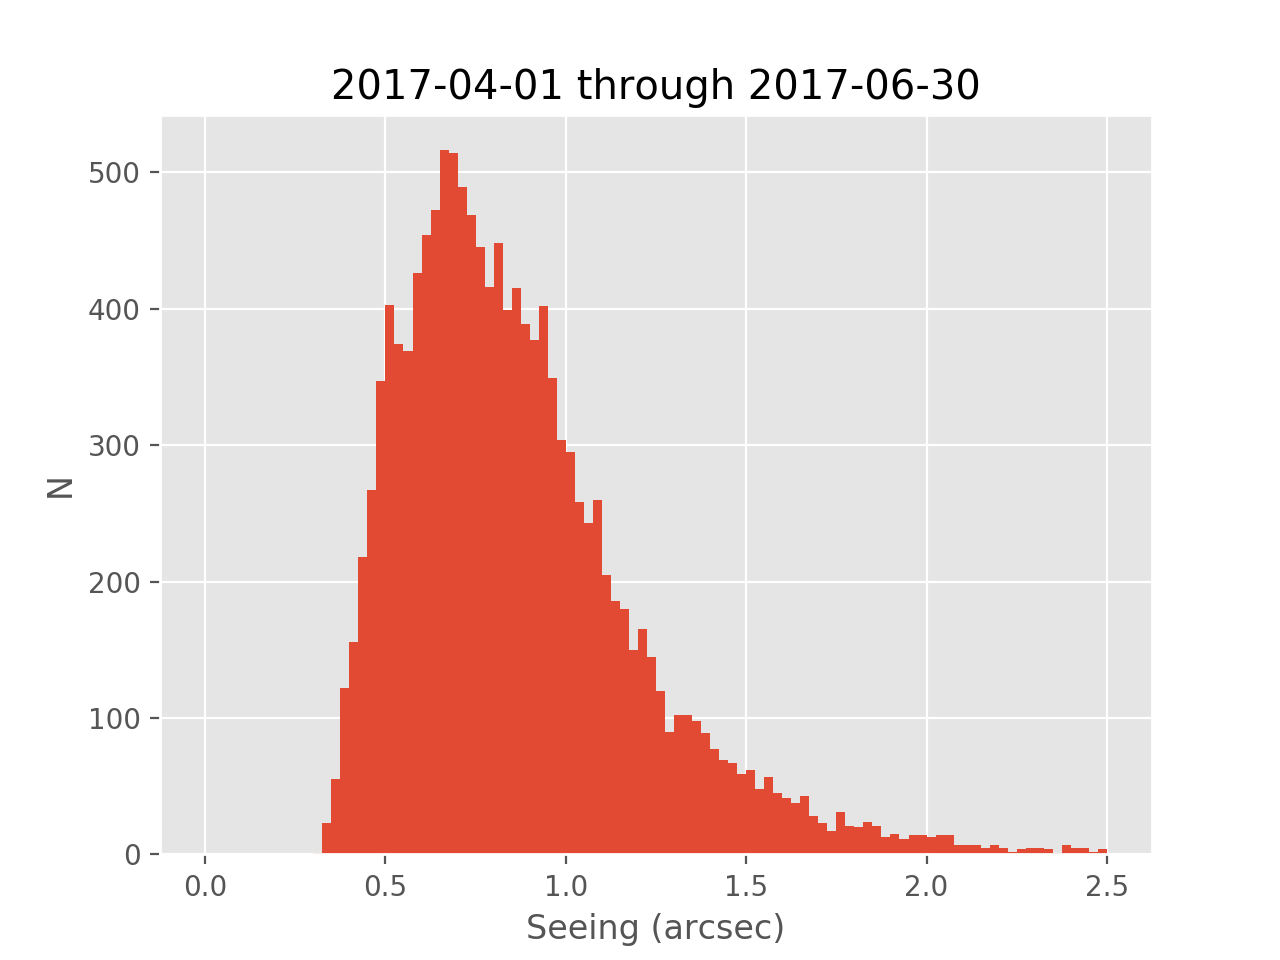

In [26]:
trimdata.hist(column='seeing', bins=100, range=(0.0, 2.5))
plt.title("2017-04-01 through 2017-06-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [8]:
sigma, loc, exp_mu = scipy.stats.lognorm.fit(trimdata['seeing']
sigma, loc, exp_mu

(0.49219527256780737, 0.19530924094792251, 0.60314094700943199)

In [22]:
x = np.arange(0.0, 2.5, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(trimdata['seeing'])
fit_median = exp_mu + loc

<IPython.core.display.Javascript object>


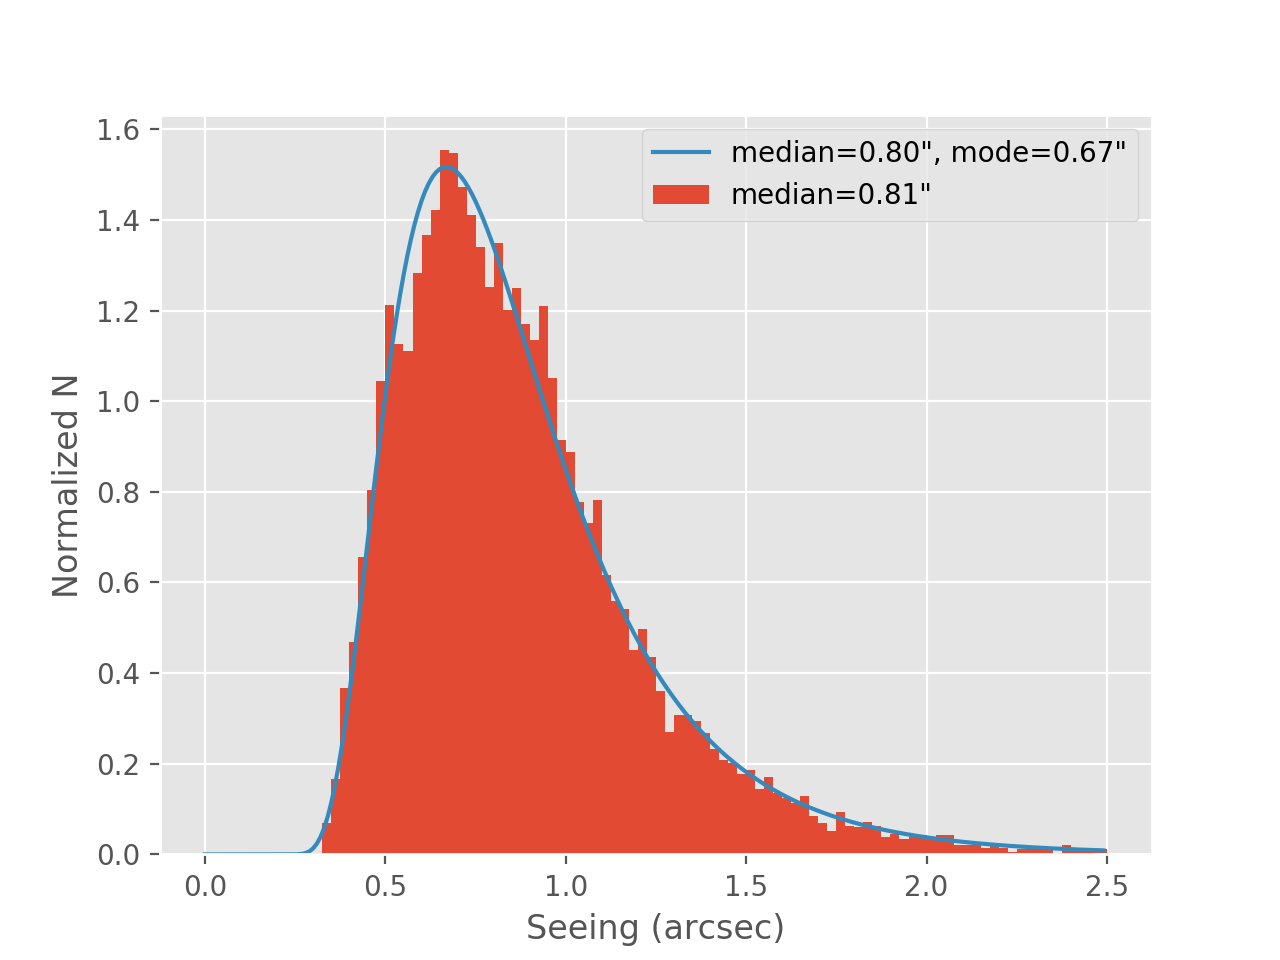

In [25]:
plt.hist(trimdata['seeing'], normed=True, bins=100, range=(0.0, 2.5), label="hist")
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Normalized N")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.show()

In [ ]:
trimdata.to_csv("seeing_2017Q2.csv")

In [ ]:
mu = np.log(exp_mu)
np.exp(mu - shape**2) + loc

In [ ]:
scipy.stats.lognorm.fit?

In [12]:
exp_mu + loc

0.79845018795735445